# Introduction

Baseline experiment - linear regression.

# Set up Environment

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.feature_selection import SelectFromModel
from math import sqrt
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             explained_variance_score, max_error)

# display all columns of dataframes in the notebook
pd.options.display.max_columns = None

# ignore warnings
warnings.filterwarnings('ignore')

# set up random seed for reproducibility
RANDOM_SEED = 42

# Load Data

In [22]:
file_path = '../data/interim/'
df_train_val = pd.read_csv(file_path + 'train_val_data.csv')
df_test = pd.read_csv(file_path + 'test_data.csv')

# Separate Train and Validation Datasets

In [23]:
# the last 10000 flights are set as validation dataset
X_train, X_val, y_train, y_val = train_test_split(df_train_val,
                                                  df_train_val['AOBTtoAIBT'],
                                                  shuffle=False,
                                                  test_size=10000)

X_test = df_test.copy()
y_test = df_test['AOBTtoAIBT']

X_train.shape, X_val.shape, X_test.shape

((734965, 40), (10000, 40), (10000, 40))

In [24]:
# write train and val into two CSV files
train_set_name = 'train_data.csv'

with open(file_path + train_set_name, "w") as my_empty_csv:
    pass

X_train.to_csv(file_path + train_set_name, mode='w', header=True, index=False)

In [25]:
val_set_name = 'val_data.csv'

with open(file_path + val_set_name, "w") as my_empty_csv:
    pass

X_val.to_csv(file_path + val_set_name, mode='w', header=True, index=False)

In [4]:
X_val.head(3)

,AOBTtoAIBT,UniqueCarrierCode,OriginAirportID,OriginCityMarketID,OriginState,OBTDelay,OBTDel15,OBTDelayGroups,SOBTtoSIBT,Distance,DistanceGroup,Num_Arr_SIBT-30,Num_Arr_SIBT-25,Num_Arr_SIBT-20,Num_Arr_SIBT-15,Num_Arr_SIBT-10,Num_Arr_SIBT-5,Num_Arr_SIBT-0,Num_Arr_SIBT+5,Num_Arr_SIBT+10,Num_Arr_SIBT+15,Num_Arr_SIBT+20,Num_Arr_SIBT+25,Num_Dep_SIBT-30,Num_Dep_SIBT-25,Num_Dep_SIBT-20,Num_Dep_SIBT-15,Num_Dep_SIBT-10,Num_Dep_SIBT-5,Num_Dep_SIBT-0,Num_Dep_SIBT+5,Num_Dep_SIBT+10,Num_Dep_SIBT+15,Num_Dep_SIBT+20,Num_Dep_SIBT+25,SIBTQuarter,SIBTMonth,SIBTDayOfMonth,SIBTDayOfWeek,SIBTHour
734965,106,DL,14027,34027,FL,12,0,0,116,545,3,4,4,8,6,16,0,5,9,3,7,12,10,8,5,7,3,29,0,10,8,4,4,3,3,4,12,21,5,19
734966,110,DL,11697,32467,FL,53,1,3,119,581,3,4,4,8,6,17,0,5,9,4,6,11,11,9,5,6,3,30,0,10,7,4,4,3,4,4,12,21,5,19
734967,99,9E,12323,32323,NC,26,1,1,105,377,2,2,6,6,7,17,0,5,8,7,11,11,12,8,8,2,4,31,0,8,5,6,2,4,4,4,12,21,5,20


The validation set are flights after 2018-12-21 6pm.

# Feature Engineering

## Categorical Variables

In [5]:
X_train.head(3)

,AOBTtoAIBT,UniqueCarrierCode,OriginAirportID,OriginCityMarketID,OriginState,OBTDelay,OBTDel15,OBTDelayGroups,SOBTtoSIBT,Distance,DistanceGroup,Num_Arr_SIBT-30,Num_Arr_SIBT-25,Num_Arr_SIBT-20,Num_Arr_SIBT-15,Num_Arr_SIBT-10,Num_Arr_SIBT-5,Num_Arr_SIBT-0,Num_Arr_SIBT+5,Num_Arr_SIBT+10,Num_Arr_SIBT+15,Num_Arr_SIBT+20,Num_Arr_SIBT+25,Num_Dep_SIBT-30,Num_Dep_SIBT-25,Num_Dep_SIBT-20,Num_Dep_SIBT-15,Num_Dep_SIBT-10,Num_Dep_SIBT-5,Num_Dep_SIBT-0,Num_Dep_SIBT+5,Num_Dep_SIBT+10,Num_Dep_SIBT+15,Num_Dep_SIBT+20,Num_Dep_SIBT+25,SIBTQuarter,SIBTMonth,SIBTDayOfMonth,SIBTDayOfWeek,SIBTHour
0,218,DL,14869,34614,UT,-2,0,-1,223,1590,7,0,0,0,0,1,0,0,2,0,0,0,0,2,1,1,0,1,0,0,3,1,0,3,1,1,1,1,7,6
1,81,F9,13204,31454,FL,-4,0,-1,88,404,2,0,0,0,0,3,0,1,0,0,0,0,1,1,1,0,1,3,0,3,1,0,3,1,0,1,1,1,7,6
2,88,EV,10980,30980,TN,302,1,12,57,106,1,0,0,0,0,3,0,0,0,0,0,1,0,1,0,1,0,4,0,2,0,3,1,0,0,1,1,1,7,6


In [6]:
# capture categorical variables in a list
cat_vars = ['UniqueCarrierCode', 'OriginAirportID', 'OriginCityMarketID', 'OriginState']

### Cardinality

In [7]:
# cardinality
X_train[cat_vars].nunique()

UniqueCarrierCode      15
OriginAirportID       168
OriginCityMarketID    151
OriginState            50
dtype: int64

UniqueCarrierCode shows low cardinality, but not the other three. Check how they affect the median target:

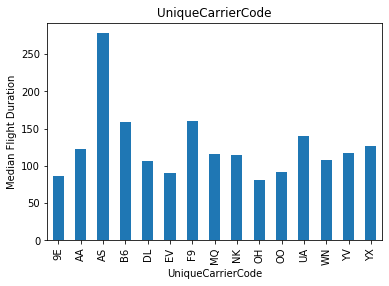

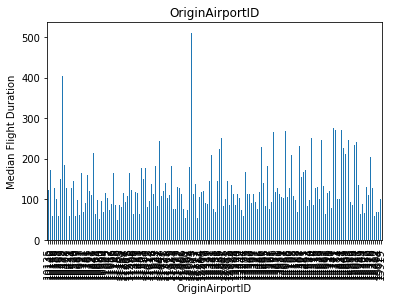

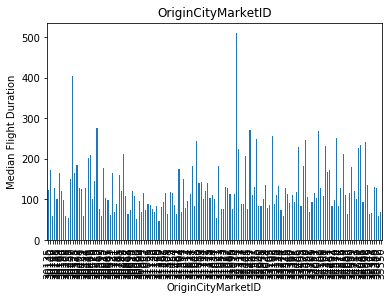

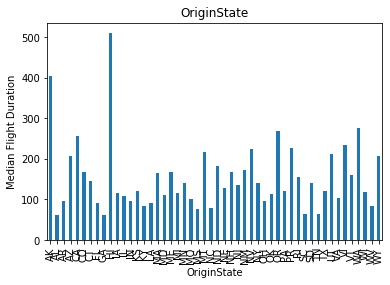

In [8]:
def analyse_cat(df, var):
    df_copy = df.copy()
    df_copy.groupby(var)['AOBTtoAIBT'].median().plot.bar()
    plt.title(var)
    plt.ylabel('Median Flight Duration')
    plt.show()
    
for var in cat_vars:
    analyse_cat(X_train, var)

### Rare Labels

In [9]:
def analyse_rare_labels(df, var, rare_perc):

    # determine the % of observations per category
    tmp = df.groupby(var)['UniqueCarrierCode'].count() / len(df)

    # return categories that are rare
    return tmp[tmp < rare_perc]


# print categories that are present in less than
# 1 % of the observations
rare_perc = 0.01
for var in cat_vars:
    print(analyse_rare_labels(X_train, var, rare_perc))

UniqueCarrierCode
AS    0.001952
B6    0.005856
F9    0.008972
MQ    0.000834
OH    0.001497
YV    0.002991
YX    0.006464
Name: UniqueCarrierCode, dtype: float64
OriginAirportID
10135    0.002493
10140    0.002280
10146    0.002177
10158    0.000495
10185    0.002403
           ...   
15380    0.000061
15412    0.006438
15607    0.002260
15624    0.005949
15919    0.004702
Name: UniqueCarrierCode, Length: 137, dtype: float64
OriginCityMarketID
30135    0.002493
30140    0.002280
30146    0.002177
30158    0.000495
30185    0.002403
           ...   
35323    0.005101
35356    0.000747
35380    0.000061
35412    0.006438
35550    0.002260
Name: UniqueCarrierCode, Length: 122, dtype: float64
OriginState
AK    0.000310
CT    0.006027
HI    0.000976
IA    0.004887
KS    0.002777
ME    0.001797
MT    0.000297
ND    0.000035
NE    0.005342
NH    0.000954
NM    0.002280
OK    0.009351
OR    0.003523
PR    0.003612
RI    0.002766
SD    0.000834
UT    0.008011
VI    0.001562
VT    0.001057
WA 

Labels that are under-represented in the dataset tend to cause over-fitting of models. They will be replaced by 'Rare'.

In [10]:
def find_frequent_labels(df, var, rare_perc):
    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset
    tmp = df.groupby(var)['UniqueCarrierCode'].count() / len(df)
    return tmp[tmp >= rare_perc].index


for var in cat_vars:

    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, rare_perc)

    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    X_val[var] = np.where(X_val[var].isin(
        frequent_ls), X_val[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

### Encode

Next, transform the strings of the categorical variables into numbers, so that we capture the monotonic relationship between the label and the target.

In [11]:
# this function will assign discrete values to the strings of the variables,
# so that the smaller value corresponds to the category that shows the smaller
# mean AOBTtoAIBT


def replace_categories(train, val, test, var, target):

    # order the categories in a variable from that with the lowest
    # house sale price, to that with the highest
    ordered_labels = train.groupby([var])[target].mean().sort_values().index

    # create a dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}

    # use the dictionary to replace the categorical strings by integers
    train[var] = train[var].map(ordinal_label)
    val[var] = val[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)


for var in cat_vars:
    replace_categories(X_train, X_val, X_test, var, 'AOBTtoAIBT')

In [12]:
# cardinality
X_train[cat_vars].nunique()

UniqueCarrierCode      9
OriginAirportID       32
OriginCityMarketID    30
OriginState           29
dtype: int64

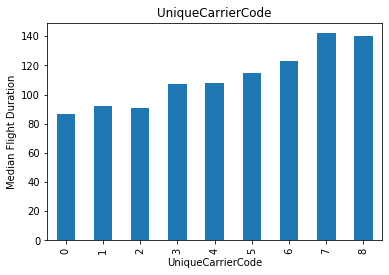

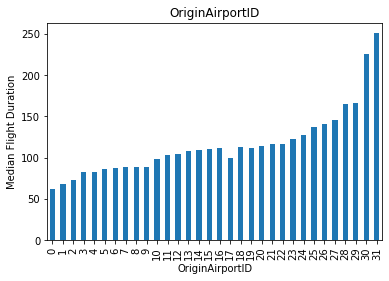

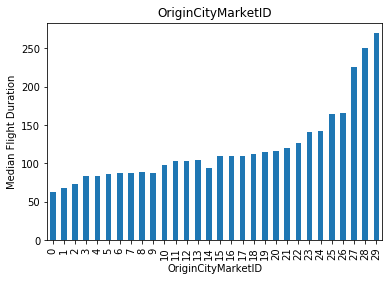

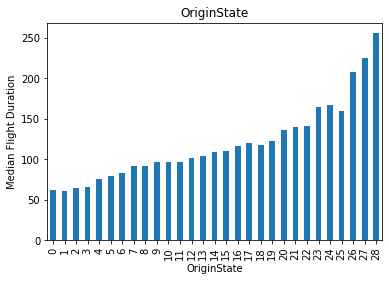

In [13]:
def analyse_cat(df, var):
    df_copy = df.copy()
    df_copy.groupby(var)['AOBTtoAIBT'].median().plot.bar()
    plt.title(var)
    plt.ylabel('Median Flight Duration')
    plt.show()
    
for var in cat_vars:
    analyse_cat(X_train, var)

## Feature Scaling

For use in linear models, features need to be either scaled or normalised.

In [14]:
X_train = X_train[X_train.columns[1:40]]
X_val = X_val[X_val.columns[1:40]]
X_test = X_test[X_test.columns[1:40]]

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Feature Selection

In [15]:
sel_ = SelectFromModel(Lasso(alpha=0.005, random_state=RANDOM_SEED))

# train Lasso model and select features
sel_.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.005, copy_X=True, fit_intercept=True,
                                max_iter=1000, normalize=False, positive=False,
                                precompute=False, random_state=42,
                                selection='cyclic', tol=0.0001,
                                warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [16]:
# let's print the number of total and selected features
selected_feats = df_train_val.iloc[:, 1:40].columns[(sel_.get_support())]

# store features
feats = selected_feats.to_list()

# let's print some stats
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feats)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 39
selected features: 36
features with coefficients shrank to zero: 3


In [17]:
# print the selected features
selected_feats

Index(['UniqueCarrierCode', 'OriginAirportID', 'OriginCityMarketID',
       'OriginState', 'OBTDelay', 'OBTDel15', 'OBTDelayGroups', 'SOBTtoSIBT',
       'Distance', 'DistanceGroup', 'Num_Arr_SIBT-30', 'Num_Arr_SIBT-25',
       'Num_Arr_SIBT-20', 'Num_Arr_SIBT-15', 'Num_Arr_SIBT-10',
       'Num_Arr_SIBT-0', 'Num_Arr_SIBT+5', 'Num_Arr_SIBT+10',
       'Num_Arr_SIBT+20', 'Num_Arr_SIBT+25', 'Num_Dep_SIBT-30',
       'Num_Dep_SIBT-25', 'Num_Dep_SIBT-20', 'Num_Dep_SIBT-15',
       'Num_Dep_SIBT-10', 'Num_Dep_SIBT-0', 'Num_Dep_SIBT+5',
       'Num_Dep_SIBT+10', 'Num_Dep_SIBT+15', 'Num_Dep_SIBT+20',
       'Num_Dep_SIBT+25', 'SIBTQuarter', 'SIBTMonth', 'SIBTDayOfMonth',
       'SIBTDayOfWeek', 'SIBTHour'],
      dtype='object')

In [18]:
X_train = np.delete(X_train, [15, 19, 27], 1)
X_val = np.delete(X_val, [15, 19, 27], 1)
X_test = np.delete(X_test, [15, 19, 27], 1)

Store the selected features in a csv file:

In [20]:
# create an empty csv file to be written
dataset_path = '..\\data\\interim\\'
dataset_name = 'selected_features.csv'

with open(dataset_path + dataset_name, "w") as my_empty_csv:
    pass

pd.Series(selected_feats).to_csv(dataset_path + dataset_name, mode='w', header=True, index=False)

# Model

## Lasso Regression

In [19]:
# set up the model
lasso = Lasso(alpha=0.005, random_state=RANDOM_SEED)

# train the model
lasso.fit(X_train, y_train)

Lasso(alpha=0.005, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)

### Evalutation of Lasso

In [20]:
# evaluate performance using the RMSE, MAE and R2
print('==========LASSO==========')

# make predictions for train set
pred_train = lasso.predict(X_train)

# determine metrics
print('train rmse: {:.3f}'.format(sqrt(mean_squared_error(y_train, pred_train))))
print('train mae: {:.3f}'.format(mean_absolute_error(y_train, pred_train)))
print('train r2: {:.3f}'.format(r2_score(y_train, pred_train)))
print('train explained variance score: {:.3f}'.format(
    explained_variance_score(y_train, pred_train)))
print('val max error: {:.3f}'.format(max_error(y_train, pred_train)))
print()

# make predictions for validation set
pred_val = lasso.predict(X_val)

# determine metrics
print('val rmse: {:.3f}'.format(sqrt(mean_squared_error(y_val, pred_val))))
print('val mae: {:.3f}'.format(mean_absolute_error(y_val, pred_val)))
print('val r2: {:.3f}'.format(r2_score(y_val, pred_val)))
print('val explained variance score: {:.3f}'.format(
    explained_variance_score(y_val, pred_val)))
print('val max error: {:.3f}'.format(max_error(y_val, pred_val)))
print()

sch_val = df_train_val['SOBTtoSIBT'][-10000:]
# determine metrics
print('sch rmse: {:.3f}'.format(sqrt(mean_squared_error(y_val, sch_val))))
print('sch mae: {:.3f}'.format(mean_absolute_error(y_val, sch_val)))
print('sch r2: {:.3f}'.format(r2_score(y_val, sch_val)))
print('sch explained variance score: {:.3f}'.format(
    explained_variance_score(y_val, sch_val)))
print('val max error: {:.3f}'.format(max_error(y_val, sch_val)))

==========LASSO==========
train rmse: 12.856
train mae: 8.670
train r2: 0.939
train explained variance score: 0.939
val max error: 419.609

val rmse: 12.796
val mae: 9.431
val r2: 0.941
val explained variance score: 0.941
val max error: 121.377

sch rmse: 14.623
sch mae: 11.702
sch r2: 0.923
sch explained variance score: 0.936
val max error: 123.000


Text(0.5, 1.0, 'Evaluation of Lasso Predictions')

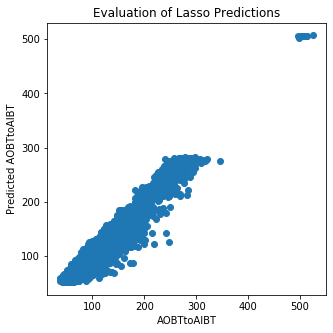

In [21]:
# evaluate our predictions respect to actual durations
plt.figure(figsize=(5,5))
plt.scatter(y_val, pred_val)
plt.xlabel('AOBTtoAIBT')
plt.ylabel('Predicted AOBTtoAIBT')
plt.title('Evaluation of Lasso Predictions')

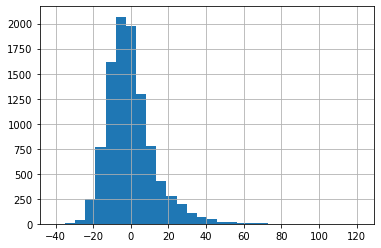

In [22]:
# let's evaluate the distribution of the errors:
# they should be fairly normally distributed
errors = y_val - lasso.predict(X_val)
errors.hist(bins=30)

The distribution of the errors follows a gaussian distribution. That suggests that our model is doing something useful.

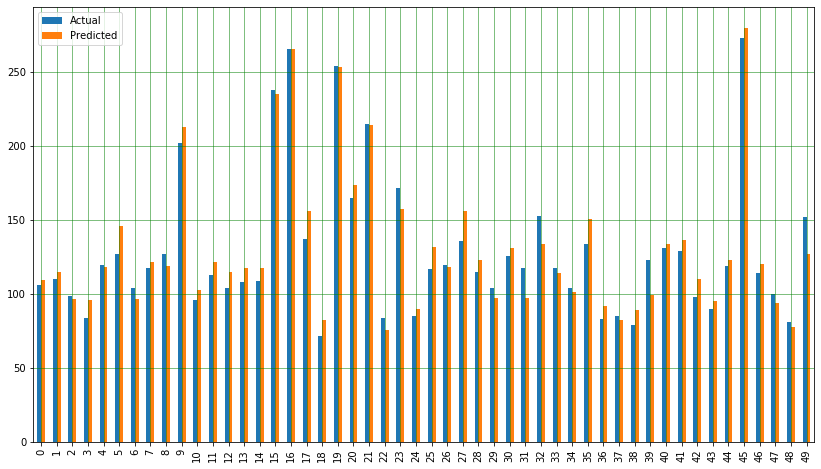

In [23]:
y_val_series = y_val.reset_index(drop=True)
# sch_val_series = sch_val.reset_index(drop=True)
pred_val_series = pd.Series(pred_val)
durations = pd.concat([y_val_series, pred_val_series], axis=1)
# durations = pd.concat([durations, sch_val_series], axis=1)

# durations = durations.rename(columns={'AOBTtoAIBT': 'Actual', 0: 'Predicted', 'SOBTtoSIBT': 'Scheduled'})
durations = durations.rename(columns={'AOBTtoAIBT': 'Actual', 0: 'Predicted'})

first_50 = durations.head(50)
first_50.plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Feature Importance

Text(0.5, 1.0, 'Feature Importance')

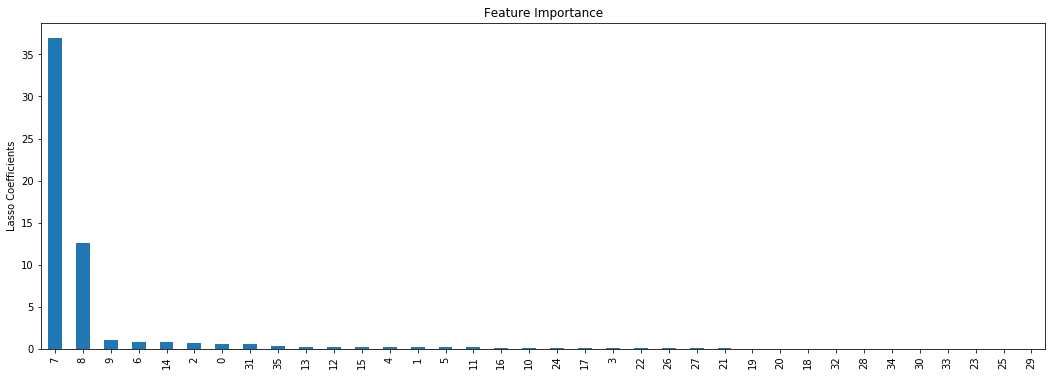

In [24]:
# Finally, look at the feature importance
importance = pd.Series(np.abs(lasso.coef_.ravel()))
#importance.index = feats
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18, 6))
plt.ylabel('Lasso Coefficients')
plt.title('Feature Importance')

## Ridge Regression

### Evaluation of Ridge

In [25]:
# set up the model
ridge = Ridge(alpha=0.005, random_state=RANDOM_SEED)

# train the model
ridge.fit(X_train, y_train)

Ridge(alpha=0.005, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=42, solver='auto', tol=0.001)

In [26]:
# evaluate performance using the RMSE, MAE and R2
print('==========RIDGE==========')

# make predictions for train set
pred_train = ridge.predict(X_train)

# determine metrics
print('train rmse: {:.3f}'.format(sqrt(mean_squared_error(y_train, pred_train))))
print('train mae: {:.3f}'.format(mean_absolute_error(y_train, pred_train)))
print('train r2: {:.3f}'.format(r2_score(y_train, pred_train)))
print('train explained variance score: {:.3f}'.format(
    explained_variance_score(y_train, pred_train)))
print('val max error: {:.3f}'.format(max_error(y_train, pred_train)))
print()

# make predictions for validation set
pred_val = ridge.predict(X_val)

# determine metrics
print('val rmse: {:.3f}'.format(sqrt(mean_squared_error(y_val, pred_val))))
print('val mae: {:.3f}'.format(mean_absolute_error(y_val, pred_val)))
print('val r2: {:.3f}'.format(r2_score(y_val, pred_val)))
print('val explained variance score: {:.3f}'.format(
    explained_variance_score(y_val, pred_val)))
print('val max error: {:.3f}'.format(max_error(y_val, pred_val)))
print()

# determine metrics
print('sch rmse: {:.3f}'.format(sqrt(mean_squared_error(y_val, sch_val))))
print('sch mae: {:.3f}'.format(mean_absolute_error(y_val, sch_val)))
print('sch r2: {:.3f}'.format(r2_score(y_val, sch_val)))
print('sch explained variance score: {:.3f}'.format(
    explained_variance_score(y_val, sch_val)))
print('val max error: {:.3f}'.format(max_error(y_val, sch_val)))

==========RIDGE==========
train rmse: 12.856
train mae: 8.669
train r2: 0.939
train explained variance score: 0.939
val max error: 419.717

val rmse: 12.795
val mae: 9.432
val r2: 0.941
val explained variance score: 0.941
val max error: 121.338

sch rmse: 14.623
sch mae: 11.702
sch r2: 0.923
sch explained variance score: 0.936
val max error: 123.000


### Feature Importance

Text(0.5, 1.0, 'Feature Importance')

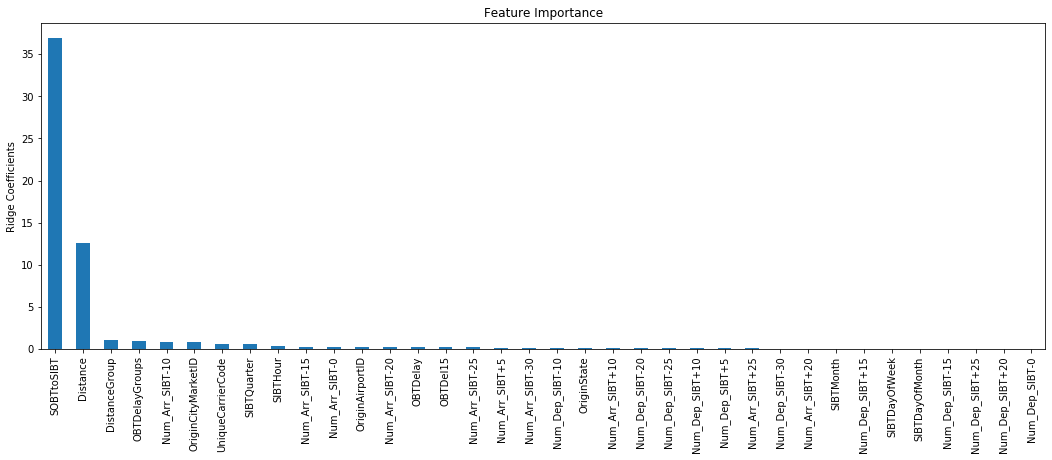

In [27]:
# Finally, look at the feature importance
importance = pd.Series(np.abs(ridge.coef_.ravel()))
importance.index = feats
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18, 6))
plt.ylabel('Ridge Coefficients')
plt.title('Feature Importance')

# Ridge Regressor on Test Set

In [28]:
# evaluate performance using the RMSE, MAE and R2
print('==========RIDGE==========')

pred_test = ridge.predict(X_test)

# determine metrics
print('test rmse: {:.3f}'.format(sqrt(mean_squared_error(y_test, pred_test))))
print('test mae: {:.3f}'.format(mean_absolute_error(y_test, pred_test)))
print('test r2: {:.3f}'.format(r2_score(y_test, pred_test)))
print('test explained variance score: {:.3f}'.format(
    explained_variance_score(y_test, pred_test)))
print('test max error: {:.3f}'.format(max_error(y_test, pred_test)))
print()

sch_test = df_test['SOBTtoSIBT']
# determine metrics
print('sch rmse: {:.3f}'.format(sqrt(mean_squared_error(y_test, sch_test))))
print('sch mae: {:.3f}'.format(mean_absolute_error(y_test, sch_test)))
print('sch r2: {:.3f}'.format(r2_score(y_test, sch_test)))
print('sch explained variance score: {:.3f}'.format(
    explained_variance_score(y_test, sch_test)))
print('val max error: {:.3f}'.format(max_error(y_test, sch_test)))

==========RIDGE==========
test rmse: 12.794
test mae: 8.826
test r2: 0.941
test explained variance score: 0.941
test max error: 180.320

sch rmse: 14.384
sch mae: 11.147
sch r2: 0.925
sch explained variance score: 0.939
val max error: 175.000


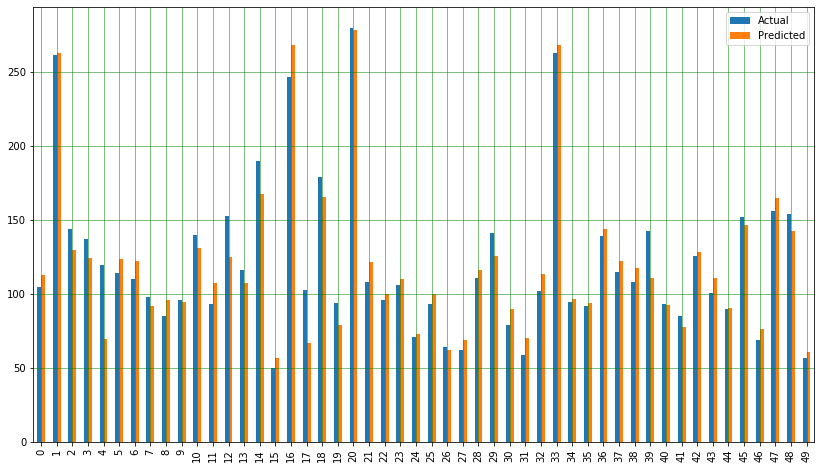

In [29]:
y_test_series = y_test.reset_index(drop=True)
pred_test_series = pd.Series(pred_test)
durations = pd.concat([y_test_series, pred_test_series], axis=1)

durations = durations.rename(columns={'AOBTtoAIBT': 'Actual', 0: 'Predicted'})

first_50 = durations.head(50)
first_50.plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()